##### Load dependencies

In [69]:
import numpy as np
import glob
import os
# from pathlib import Path

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import ipywidgets as widgets
from ipywidgets import VBox
from ipywidgets import HBox, Label
from IPython.display import clear_output#, display

from cil.framework import ImageData
from cil.io import NikonDataReader, TIFFWriter
from cil.processors import TransmissionAbsorptionConverter, CentreOfRotationCorrector#, RingRemover
from cil.recon import FDK

from cil.utilities.display import show_geometry, show2D
from cil.utilities.jupyter import islicer

from cil.plugins.astra import ProjectionOperator
from cil.optimisation.algorithms import CGLS, SIRT, PDHG, SPDHG, FISTA
from cil.optimisation.utilities import callbacks
from cil.optimisation.functions import IndicatorBox, L2NormSquared, LeastSquares, MixedL21Norm, BlockFunction, ZeroFunction, TotalVariation
from cil.optimisation.operators import BlockOperator, GradientOperator

import k3d, base64

Function definition

In [2]:
def plot_grid(image_set, rows, cols, title="Image", vmin=None, vmax=None, fname=None):

    number_of_images = rows * cols
    number_of_slices = image_set.shape[0]
    # fname = os.path.join(data_path, "projections.png");

    slice_ID_set = np.arange(0, number_of_slices, number_of_slices // number_of_images)

    fig = plt.figure(figsize=(15, 15))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for ax, slide_ID in zip(grid, slice_ID_set):
        # Iterating over the grid returns the Axes.
        ax.imshow(image_set[slide_ID], cmap="grey", vmin=vmin, vmax=vmax)
        ax.set_title(title + " " + str(slide_ID + 1) + "/" + str(len(image_set)))
        ax.set_xticks([])
        ax.set_yticks([])

    if fname is not None:
        fig.savefig(fname);
        
    plt.show()

def comparison(reconstruction_set, number_of_images, fname=None):
    
    cols = len(reconstruction_set);
    rows = number_of_images;

    number_of_slices = reconstruction_set[list(reconstruction_set.keys())[0]].shape[0]

    slice_ID_set = np.arange(0, number_of_slices, number_of_slices // number_of_images)

    fig = plt.figure(figsize=(15, 15))
    
    vmin=0.0;
    default_vmax = reconstruction_set["FDK"].max() * 0.95
    
    for i, key in enumerate(reconstruction_set.keys()):
        
        # if "ProjectionOperator" in key:
        #     vmax = reconstruction_set[key].max() * 0.85
        # else:
        #     vmax = default_vmax
        vmax = reconstruction_set[key].max() * 0.85

        for j in range(rows):
        
            idx = j * cols + i;
            ax = plt.subplot(rows, cols, idx + 1)
            ax.imshow(reconstruction_set[key][slice_ID_set[j]], cmap="grey", vmin=vmin, vmax=vmax);
            ax.set_xticks([]);
            ax.set_yticks([]);

            if j == 0:
                ax.set_title(key);
                
            if i == 0:
                ax.set_ylabel("Slice " + str(slice_ID_set[j] + 1) + "/" + str(reconstruction_set[key].shape[1]), rotation=90, size='large')                

    if fname is not None:
        fig.savefig(fname);

    plt.show()    

##### Load the data

Specify the parent directory and list the scans

In [3]:
# Specify the parent directory
parent_directory = "data"
# parent_directory = "/run/media/fpvidal/DATA/CT/2022/NXCT0462_AG/WOOD-80kV"
parent_directory = "/run/media/fpvidal/DATA/CT/2022/NXCT0462_AG/Pellet/Pellet4-XTH-B1-180kV-Cu-1.6mm"

# Make sure the directory exists
if not os.path.isdir(parent_directory):
    raise IOError(parent_directory + " is not a directory.")
    
# list the scans in the directory
files = glob.glob(os.path.join(parent_directory, '*.xtekct'))

# Make sure the directory contains a single xtekct file
if len(files) == 0:
    raise IOError(parent_directory + " is a directory but it does not contain any xtekct file.")

if len(files) > 1:
    print("WARNING:", parent_directory + " is a directory but it contains several xtekct files. The first one", files[0], "will be used by default.")


for i, file in enumerate(files):
    print(str(i) + ': ' + str(file))

0: /run/media/fpvidal/DATA/CT/2022/NXCT0462_AG/Pellet/Pellet4-XTH-B1-180kV-Cu-1.6mm/NXCT0462_AG-Pellet4-XTH-Cu.xtekct


choose the number of the file in the files list 

In [4]:
file_menu = widgets.Dropdown(
    options=files,
    value=files[0],
    description='File:',
    disabled=False,
)
file_menu

Dropdown(description='File:', options=('/run/media/fpvidal/DATA/CT/2022/NXCT0462_AG/Pellet/Pellet4-XTH-B1-180k…

In [5]:
filename = file_menu.value

In [6]:
use_binning_checkbox = widgets.Checkbox(
    value=False,
    description='Use binning',
    disabled=False,
    indent=False
);

binning_xy_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=10,
    step=1,
    orientation='horizontal',
    readout=True,
    readout_format='d'
);

binning_z_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=10,
    step=1,
    orientation='horizontal',
    readout=True,
    readout_format='d'
);

binning_xy_label = Label('Binning along the X- & Y-axes:');

binning_z_label = Label('Binning along the Z-axis:');

layout = widgets.Layout(width='600px')

out_vbox = VBox(children=[
        HBox([binning_xy_label, binning_xy_slider]),
        HBox([binning_z_label, binning_z_slider]),
    ]);

if use_binning_checkbox.value == False:
    out_vbox.layout.visibility = 'hidden'

out = widgets.Output()

def on_value_change(change):
    with out:
        if use_binning_checkbox.value:
            out_vbox.layout.visibility = 'visible'
            
        else:
            out_vbox.layout.visibility = 'hidden'

        clear_output()
        
    out_vbox.children=[
        HBox([Label('Binning along the X- & Y-axes:'), binning_xy_slider]),
        HBox([Label('Binning along the Z-axis:'), binning_z_slider])
    ];

use_binning_checkbox.observe(on_value_change, names='value')

print("If binning makes use of an odd number, the centre of rotation algorithm fails to start.")
HBox(children=[use_binning_checkbox, out_vbox])


If binning makes use of an odd number, the centre of rotation algorithm fails to start.


In [8]:
# Instanciate the reader
if use_binning_checkbox:
    reader = NikonDataReader(file_name=filename, roi= {'horizontal':(None, None, binning_xy_slider.value),'vertical':(None, None, binning_xy_slider.value),'angle':(None, None, binning_z_slider.value)}, mode="bin");
else:
    reader = NikonDataReader(file_name=filename);
    
# Read the data
data = reader.read()

In [9]:
# Inspect the geometry
print(data.geometry);

3D Cone-beam tomography
System configuration:
	Source position: [  0.     , -58.22464,   0.     ]
	Rotation axis position: [-0.,  0.,  0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ -0.     , 913.51136,   0.     ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [798 574]
	Pixel size: [0.508 0.508]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1253
	Angles 0-9 in degrees: [14.53215 , 14.244858, 13.957565, 13.670273, 13.38298 , 13.095688,
 12.808395, 12.521088, 12.233795, 11.946503]
	Angles 1243-1252 in degrees: [-342.57532, -342.86255, -343.1499 , -343.4372 , -343.7245 , -344.01172,
 -344.29907, -344.58636, -344.87366, -345.1609 ]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


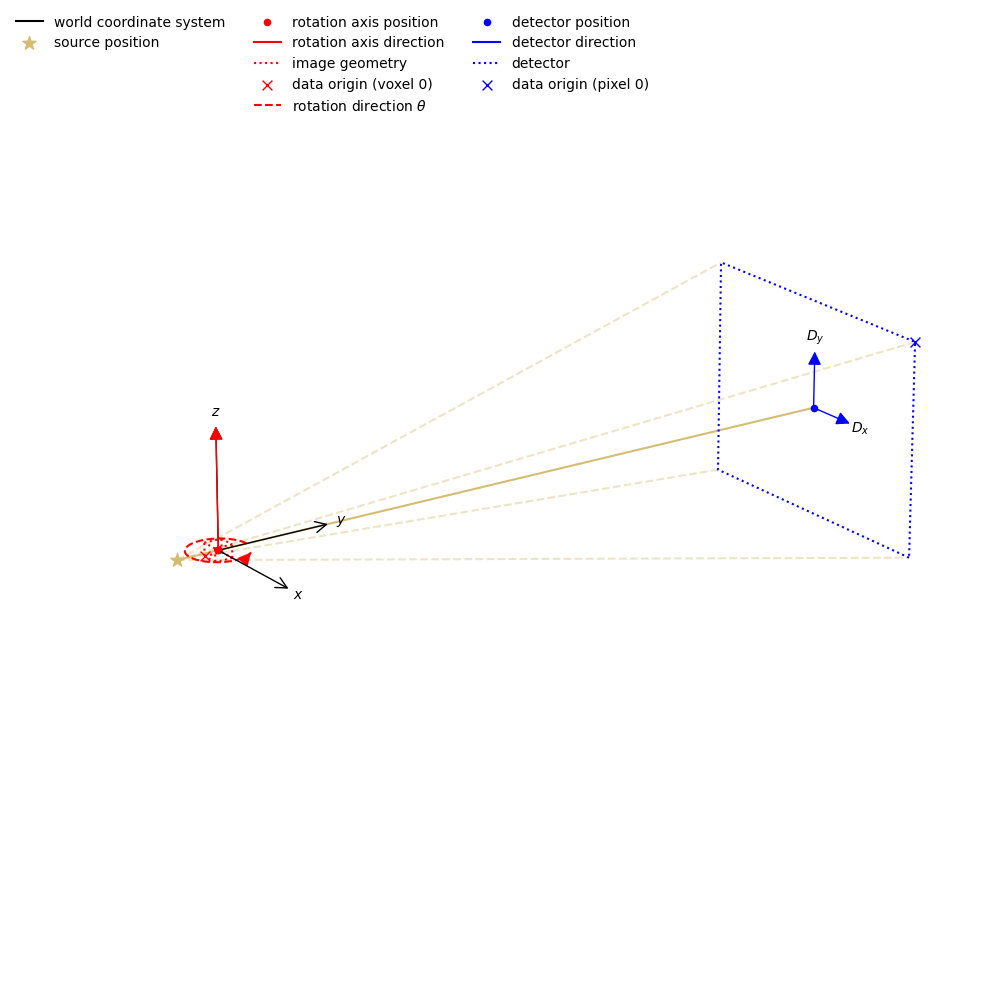

Saved image as /run/media/fpvidal/DATA/CT/2022/NXCT0462_AG/Pellet/Pellet4-XTH-B1-180kV-Cu-1.6mm/geometry.png


<Figure size 640x480 with 0 Axes>

In [10]:
# Plot and save the geometry
fname = os.path.join(parent_directory, "geometry.png");
show_geometry(data.geometry).save(fname);

In [11]:
# Inspect the projections
islicer(data, direction='angle', origin="upper-left");

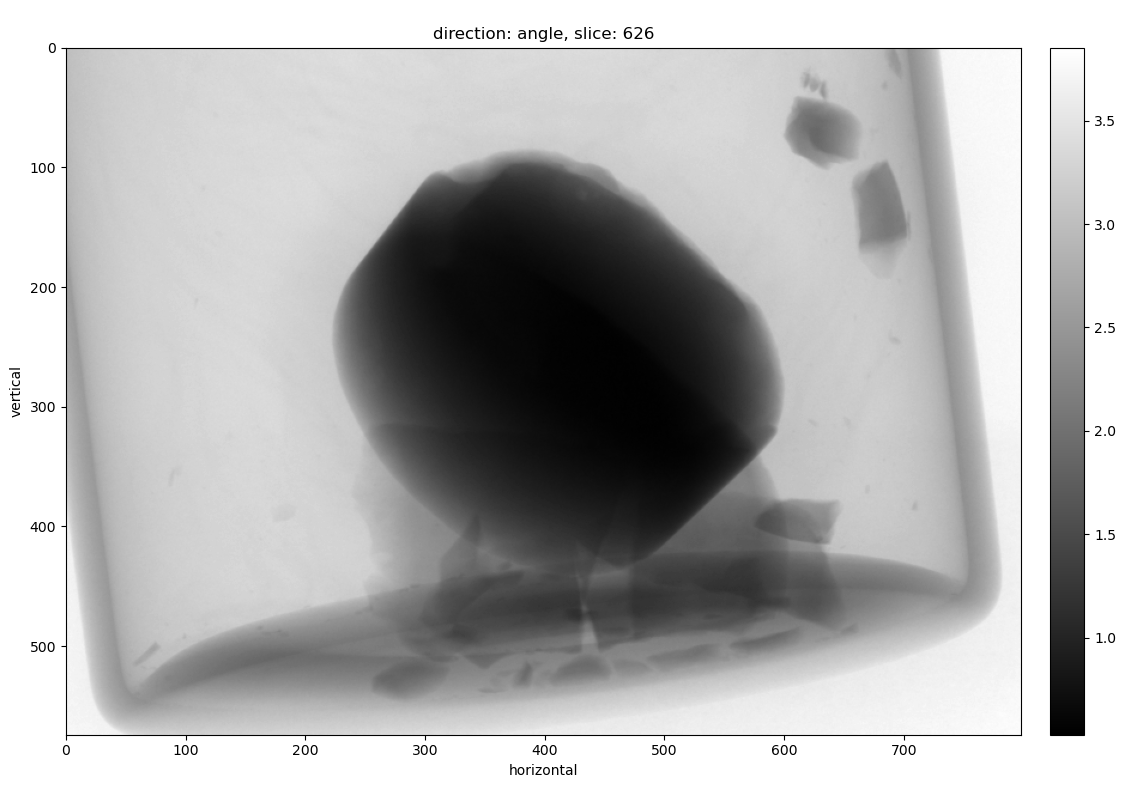

In [12]:
show2D(data, origin="upper-left");

##### Normalise using $-\ln\left(\frac{data}{white\_level}\right)$

##### Transmission to absorption 

Use the CIL `TransmissionAbsorptionConverter`
- If there are negative numbers in the data, specify a low value in `min_intensity` to clip these values before calculating -log

In [13]:
data_corr = TransmissionAbsorptionConverter(min_intensity=0.00001, white_level=data.max())(data);

Plot the sinogram of the centre slice using show2D

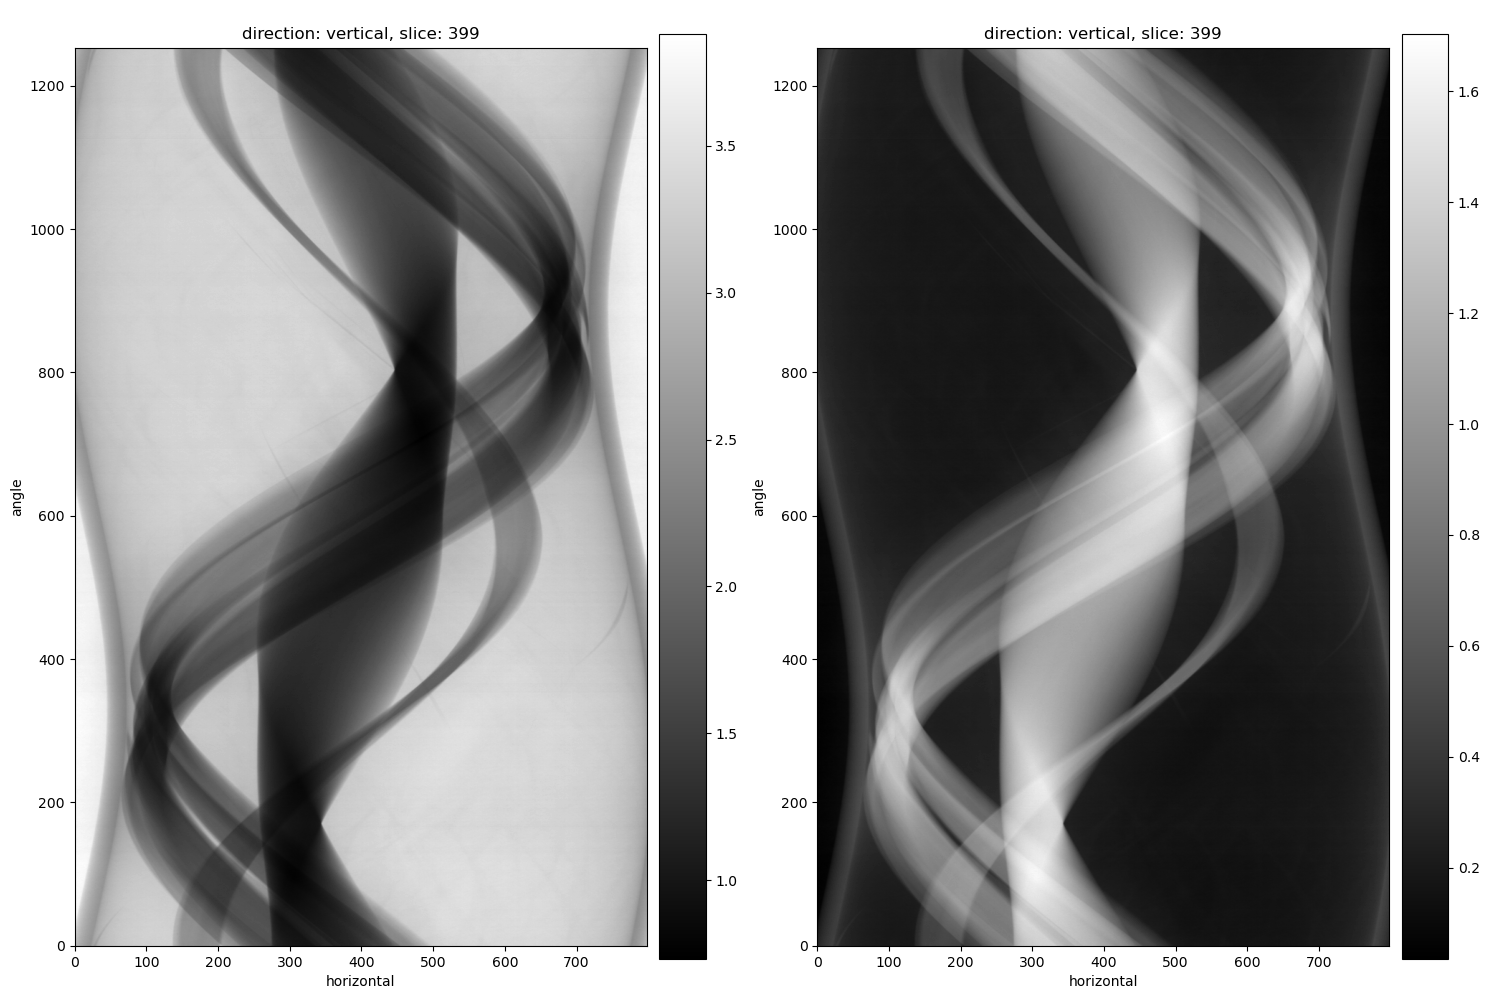

In [14]:
show2D([data, data_corr], slice_list=('vertical', data.shape[2] // 2))

##### Get a vertical slice of the data

##### Filtered back projection

We use the CIL filtered back projection. By default this uses a Ram-Lak

In [15]:
data_slice = data_corr.get_slice(vertical="centre")

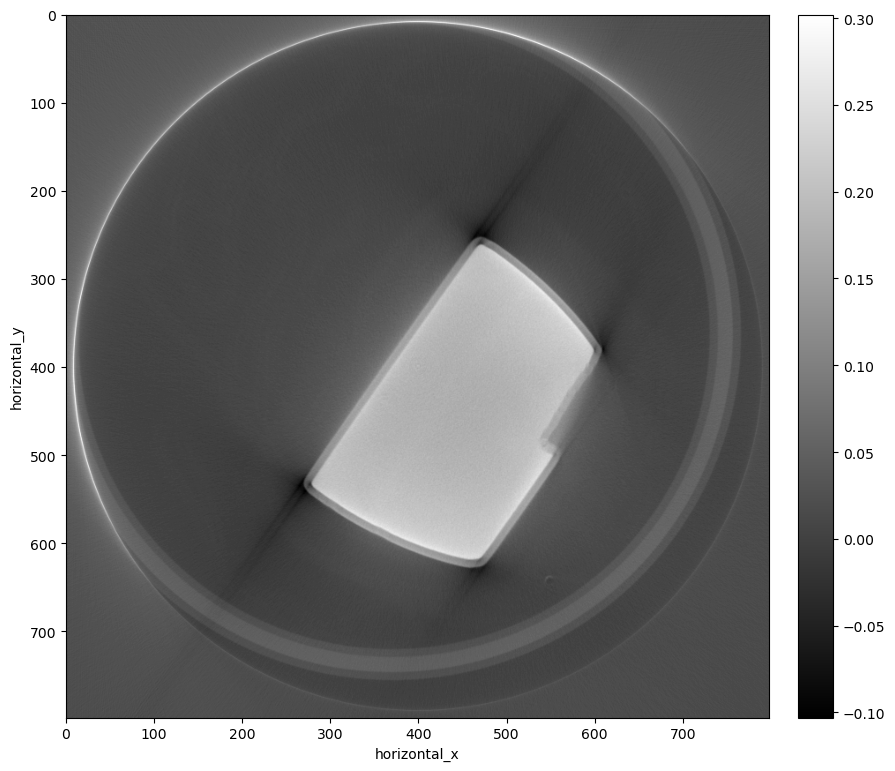

In [16]:
ig = data_slice.geometry.get_ImageGeometry();
recons_FDK_before = FDK(data_slice, ig).run(verbose=False)
show2D(recons_FDK_before, origin="upper-left")

In [17]:
voxel_num_x_slider = widgets.IntSlider(
    value=ig.voxel_num_x,
    min=1,
    max=ig.voxel_num_x,
    step=1,
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

voxel_num_y_slider = widgets.IntSlider(
    value=ig.voxel_num_y,
    min=1,
    max=ig.voxel_num_y,
    step=1,
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

voxel_num_z_slider = widgets.IntSlider(
    value=data.shape[1],
    min=1,
    max=data.shape[1],
    step=1,
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Box(children=[voxel_num_x, voxel_num_y, voxel_num_z])
VBox(children=[
    HBox([Label('Number of voxels along the X-axis:'), voxel_num_x_slider]),
    HBox([Label('Number of voxels along the Y-axis:'), voxel_num_y_slider]),
    HBox([Label('Number of voxels along the Z-axis:'), voxel_num_z_slider])
])

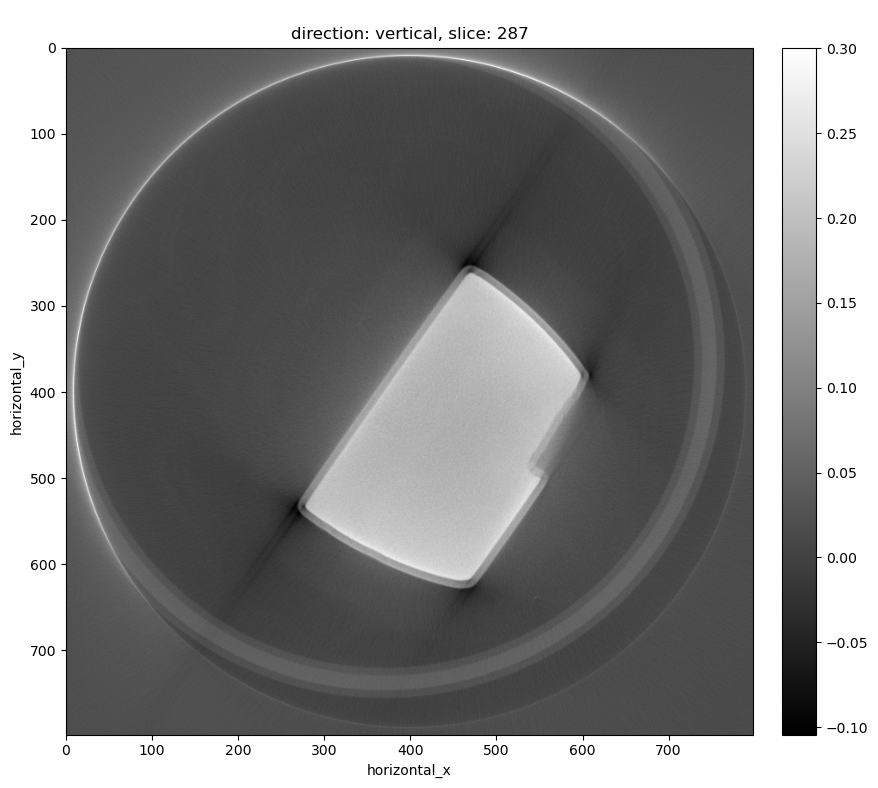

In [18]:
# Define a ROI to reconstruct the 3 middle slices only
ig = data_corr.geometry.get_ImageGeometry();
ig.voxel_num_x = voxel_num_x_slider.value
ig.voxel_num_y = voxel_num_y_slider.value
ig.voxel_num_z = voxel_num_z_slider.value

reco_before = FDK(data_corr, ig).run(verbose=False)
show2D(reco_before, origin="upper-left")

In [19]:
islicer(reco_before, origin="upper-left")

##### Centre of rotation correction

In [20]:
processor = CentreOfRotationCorrector.image_sharpness(slice_index='centre', tolerance=1/125)
processor.set_input(data_corr)
processor.get_output(out=data_corr)

In [21]:
directory_path = os.path.join(parent_directory, "FDK_CIL");

if not os.path.exists(directory_path):
    os.mkdir(directory_path)

# Perform the actual CT reconstruction
recons_FDK:ImageData | None = FDK(data_corr, ig).run(verbose=False)

writer = TIFFWriter(data=recons_FDK, file_name=os.path.join(directory_path, "slice"))
writer.write()

recons_FDK_cil_array = recons_FDK.as_array()

vmin = 0.0
vmax = recons_FDK_cil_array.max() * 0.85

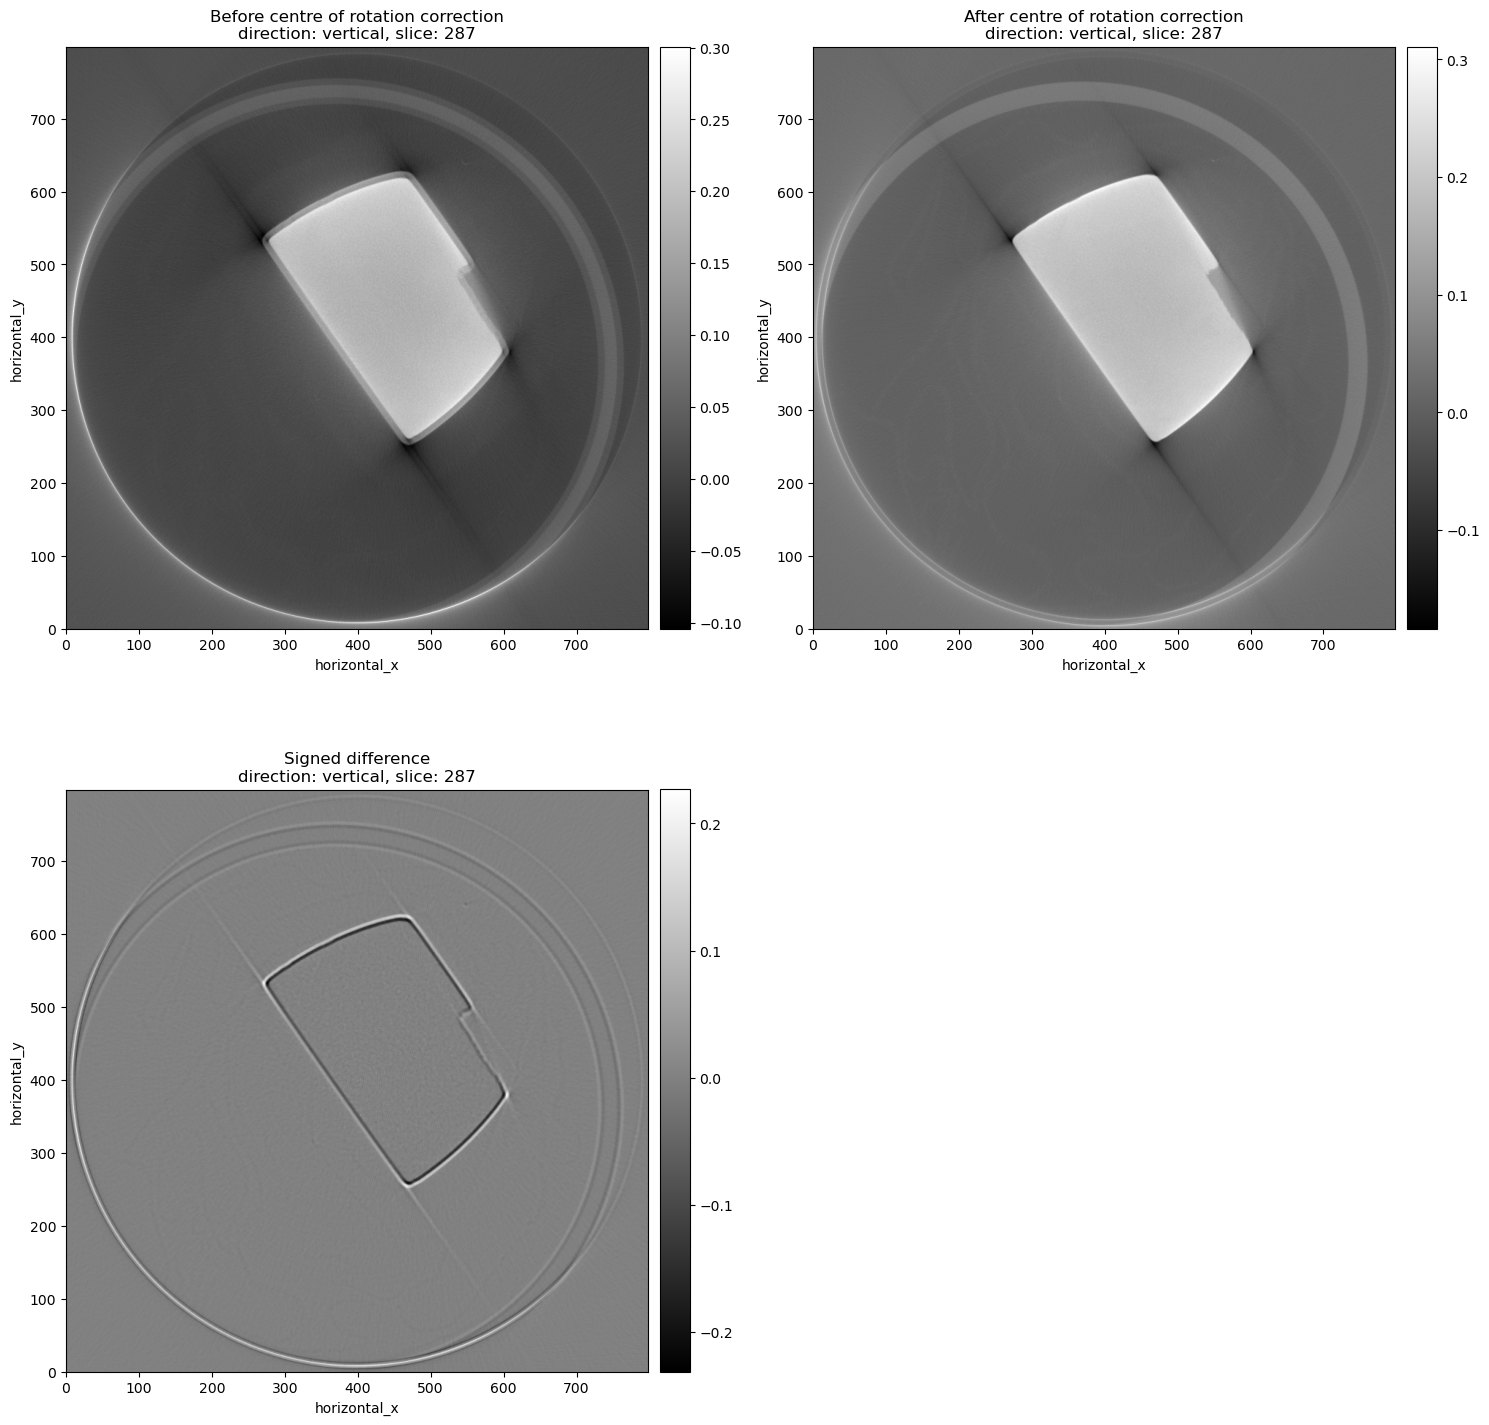

In [22]:
recons_FDK = FDK(data_corr, ig).run(verbose=False)
show2D([reco_before, recons_FDK, reco_before - recons_FDK],
    ['Before centre of rotation correction','After centre of rotation correction','Signed difference'])

Print the geometry to see the rotation axis has been changed

In [23]:
print(data_corr.geometry)

3D Cone-beam tomography
System configuration:
	Source position: [  0.     , -58.22464,   0.     ]
	Rotation axis position: [0.13182711, 0.        , 0.        ]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ -0.     , 913.51136,   0.     ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [798 574]
	Pixel size: [0.508 0.508]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1253
	Angles 0-9 in degrees: [14.53215 , 14.244858, 13.957565, 13.670273, 13.38298 , 13.095688,
 12.808395, 12.521088, 12.233795, 11.946503]
	Angles 1243-1252 in degrees: [-342.57532, -342.86255, -343.1499 , -343.4372 , -343.7245 , -344.01172,
 -344.29907, -344.58636, -344.87366, -345.1609 ]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


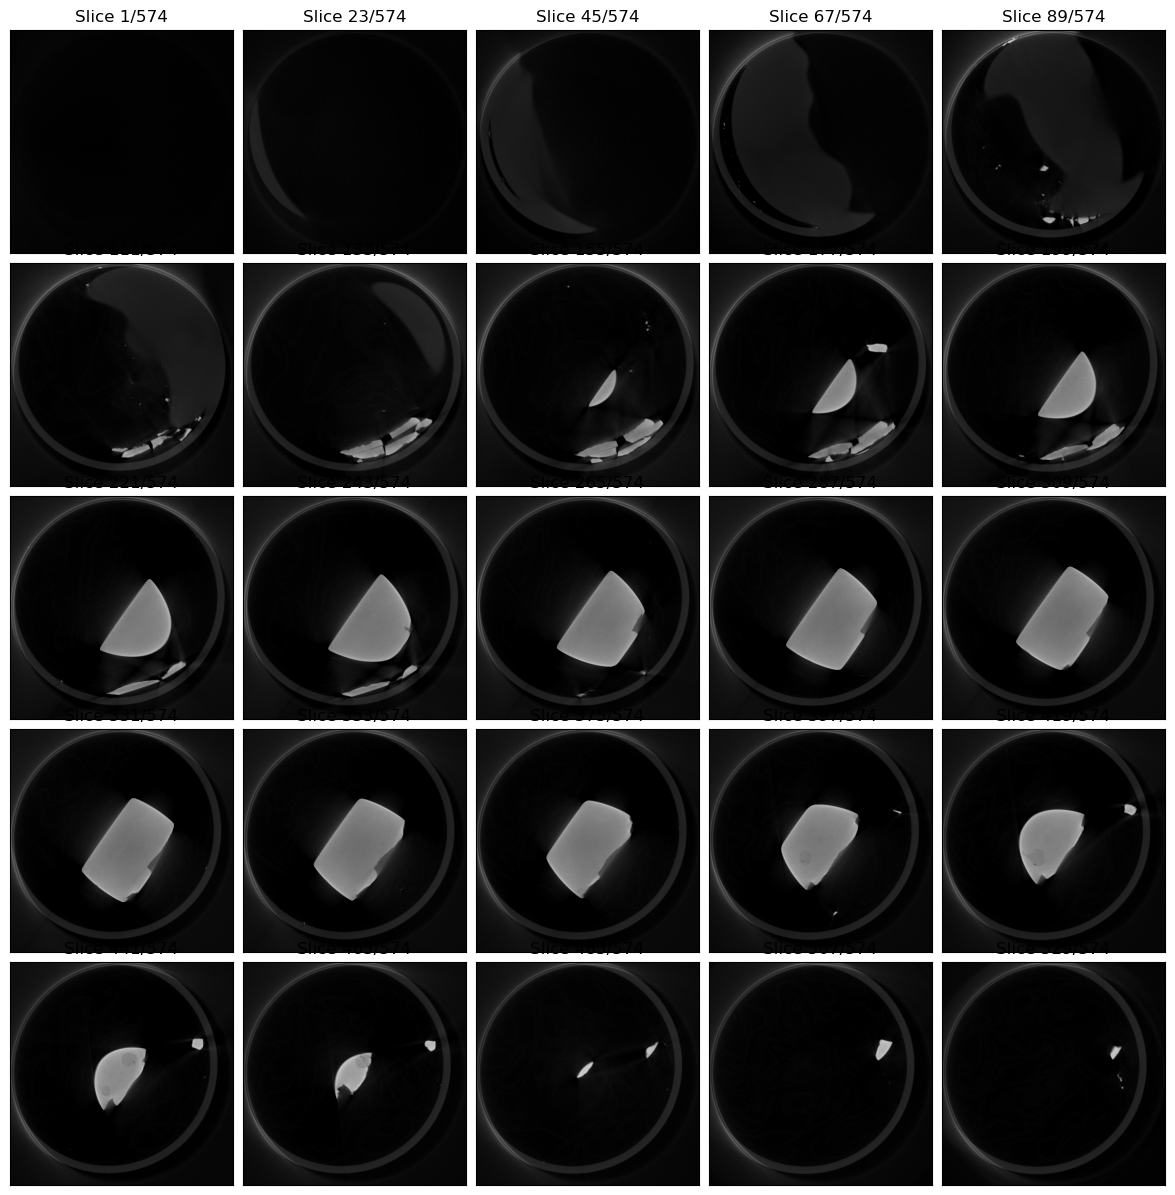

In [24]:
plot_grid(recons_FDK_cil_array, 5, 5, title="Slice", vmin=vmin, vmax=vmax);

# Per-projection geometry with CGLS

In [25]:
# Create the initial estimate, a black volume to start with
initial = ig.allocate(0)

In [26]:
data_corr.reorder('astra')
A = ProjectionOperator(ig, data_corr.geometry, "gpu")

In [27]:
directory_path = os.path.join(parent_directory, "CGLS");

if not os.path.exists(directory_path):
    os.mkdir(directory_path)

# Intantiate the reconstruction algorithm
update_objective_interval = 1
cgls = CGLS(initial=initial, 
            operator=A, 
            data=data_corr,
            max_iteration=10,
            update_objective_interval=update_objective_interval)

# Perform the CT reconstruction
cgls.run(10, verbose=1, callbacks=[callbacks.TextProgressCallback()])

# Extract the solution
recons_CIL = cgls.solution

writer = TIFFWriter(data=recons_CIL, file_name=os.path.join(directory_path, "slice"))
writer.write()

recons_CGLS_cil_array = np.copy(recons_CIL.as_array())

     0/10         ?it/s
     1/10     14.24s/it, objective=+5.475e+07
     2/10     13.57s/it, objective=+1.285e+07
     3/10     13.07s/it, objective=+7.002e+06
     4/10     12.96s/it, objective=+3.981e+06
     5/10     12.96s/it, objective=+2.486e+06
     6/10     12.88s/it, objective=+1.821e+06
     7/10     12.78s/it, objective=+1.404e+06
     8/10     12.74s/it, objective=+1.089e+06
     9/10     12.64s/it, objective=+9.770e+05
    10/10     12.60s/it, objective=+8.404e+05
    10/10     12.84s/it



Text(0, 0.5, 'Objective value')

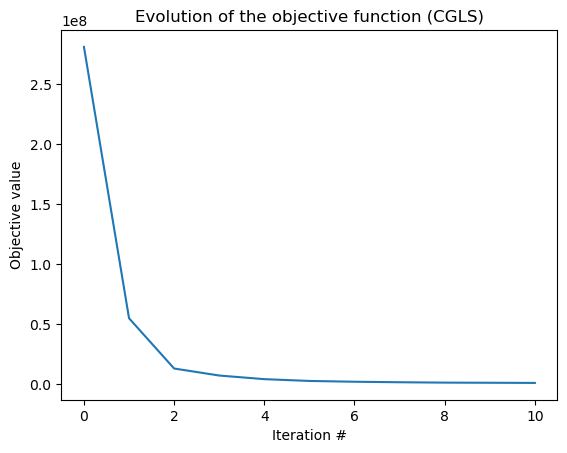

In [28]:
plt.title("Evolution of the objective function (CGLS)")
plt.plot(update_objective_interval*np.arange(len(cgls.objective)), cgls.objective)
plt.xlabel("Iteration #")
plt.ylabel("Objective value")

In [29]:
del recons_CIL, cgls, writer

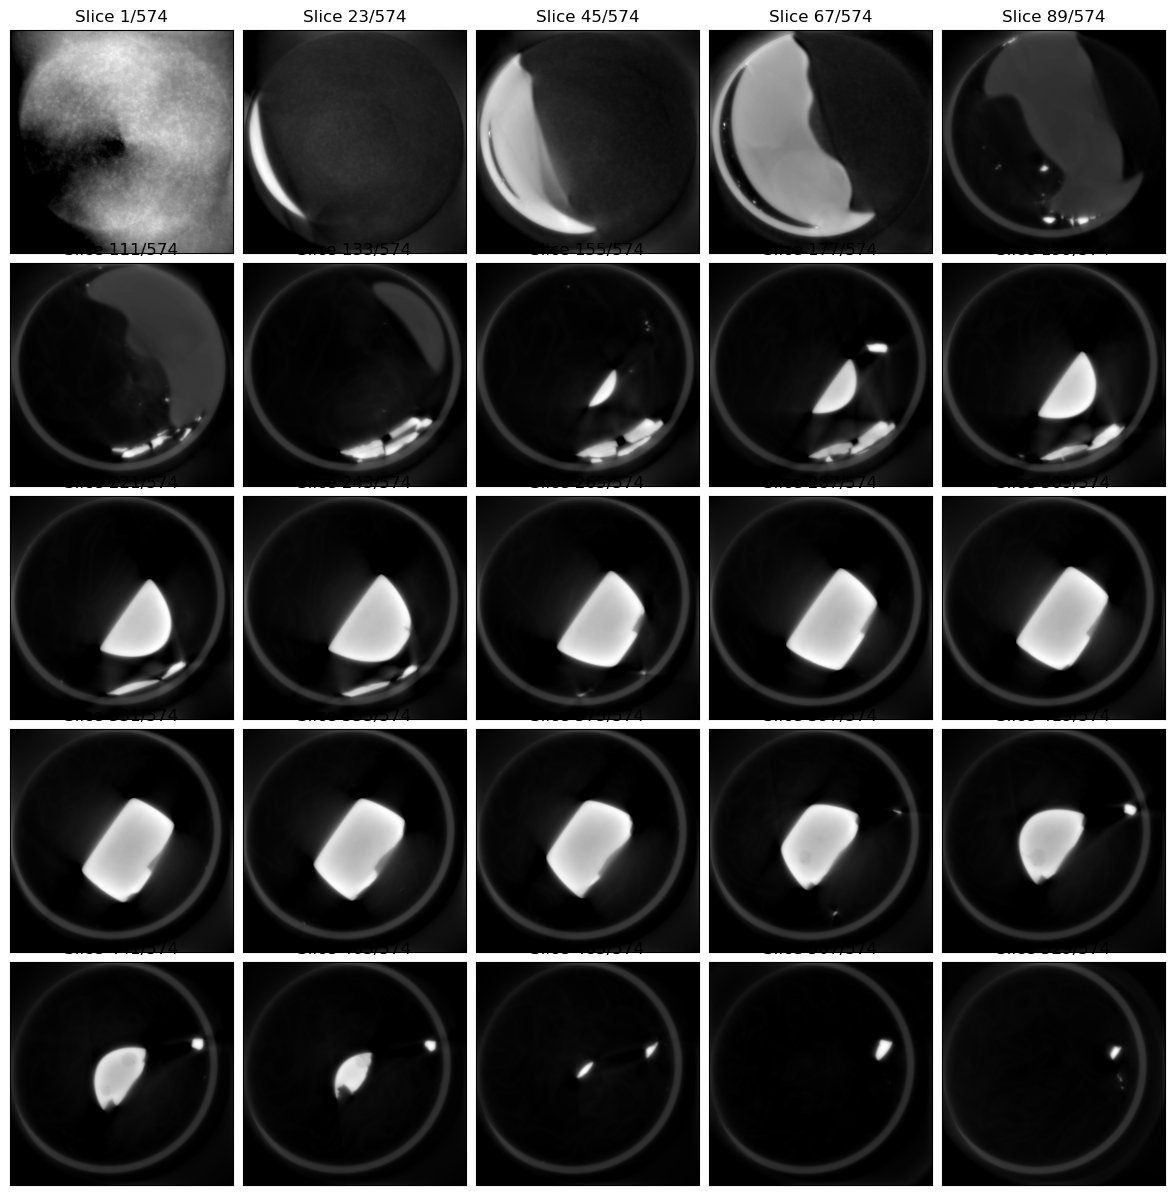

In [30]:
plot_grid(recons_CGLS_cil_array, 5, 5, title="Slice", vmin=vmin, vmax=None);

# Per-projection geometry with SIRT

In [31]:
constraint = IndicatorBox(lower=0)

In [32]:
directory_path = os.path.join(parent_directory, "SIRT");

if not os.path.exists(directory_path):
    os.mkdir(directory_path)

# setup SIRT
update_objective_interval = 1
sirt = SIRT(initial=initial, 
            operator=A, 
            data=data_corr,
            constraint=constraint,
            max_iteration=200,
            update_objective_interval=update_objective_interval)

# Perform the CT reconstruction
sirt.run(20, verbose=1, callbacks=[callbacks.TextProgressCallback()])

# Extract the solution
recons_CIL = sirt.solution

writer = TIFFWriter(data=recons_CIL, file_name=os.path.join(directory_path, "slice"))
writer.write()

recons_SIRT_cil_array = recons_CIL.as_array()

     0/20         ?it/s
     1/20      9.73s/it, objective=+2.278e+05
     2/20      9.81s/it, objective=+5.123e+04
     3/20     10.07s/it, objective=+3.320e+04
     4/20      9.95s/it, objective=+2.289e+04
     5/20     10.04s/it, objective=+1.677e+04
     6/20     10.00s/it, objective=+1.282e+04
     7/20      9.90s/it, objective=+1.009e+04
     8/20      9.94s/it, objective=+8.274e+03
     9/20      9.97s/it, objective=+6.905e+03
    10/20     10.07s/it, objective=+5.870e+03
    11/20     10.84s/it, objective=+5.087e+03
    12/20     11.36s/it, objective=+4.481e+03
    13/20     11.72s/it, objective=+4.036e+03
    14/20     11.90s/it, objective=+3.634e+03
    15/20     12.04s/it, objective=+3.306e+03
    16/20     12.16s/it, objective=+3.036e+03
    17/20     12.36s/it, objective=+2.811e+03
    18/20     12.34s/it, objective=+2.620e+03
    19/20     12.32s/it, objective=+2.458e+03
    20/20     12.32s/it, objective=+2.318e+03
    20/20     11.22s/it



Text(0, 0.5, 'Objective value')

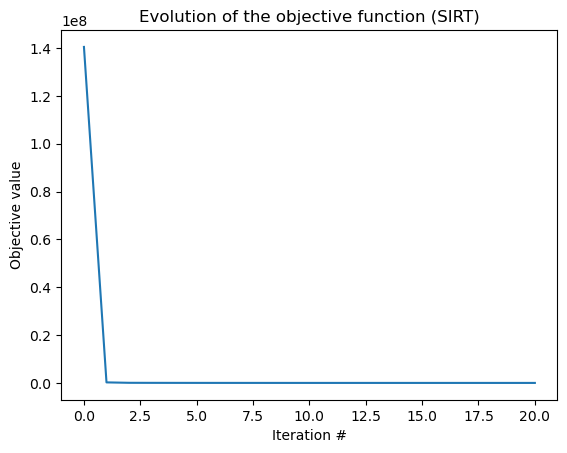

In [33]:
plt.title("Evolution of the objective function (SIRT)")
plt.plot(update_objective_interval*np.arange(len(sirt.objective)), sirt.objective)
plt.xlabel("Iteration #")
plt.ylabel("Objective value")

In [41]:
del recons_CIL, sirt, writer

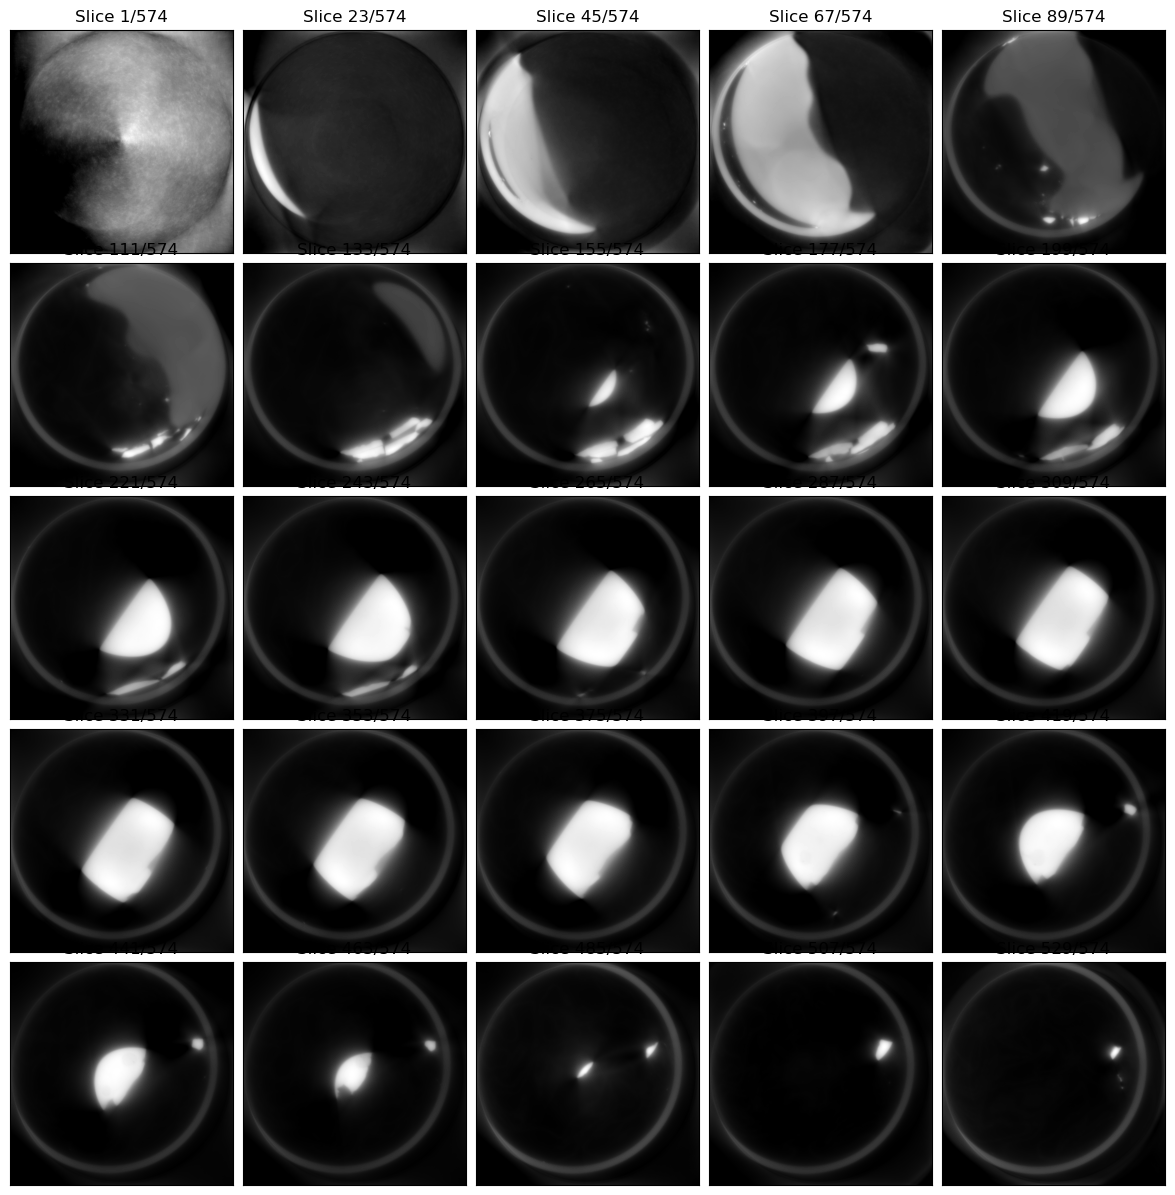

In [34]:
plot_grid(recons_SIRT_cil_array, 5, 5, title="Slice");

# Per-projection geometry with PDHG

In [45]:
directory_path = os.path.join(parent_directory, "PDHG");

if not os.path.exists(directory_path):
    os.mkdir(directory_path)

alpha = 0.02
D = GradientOperator(ig)
F = BlockFunction(L2NormSquared(b=data_corr), 
                  alpha*MixedL21Norm())
K = BlockOperator(A, 
                  D)
G = ZeroFunction()
update_objective_interval = 10
pdhg = PDHG(initial=initial,
            f=F, 
            g=G, 
            operator=K, 
            max_iteration=10000, 
            update_objective_interval=update_objective_interval)

# Perform the CT reconstruction
pdhg.run(40, verbose=1, callbacks=[callbacks.TextProgressCallback()])

# Extract the solution
recons_CIL = pdhg.solution

writer = TIFFWriter(data=recons_CIL, file_name=os.path.join(directory_path, "slice"))
writer.write()

recons_PDHG_cil_array = recons_CIL.as_array()

     0/40         ?it/s
    10/40     22.60s/it, objective=+8.141e+07
    20/40     22.68s/it, objective=+4.146e+07
    30/40     22.94s/it, objective=+3.015e+07
    40/40     22.70s/it, objective=+2.357e+07
    40/40     22.73s/it



Text(0, 0.5, 'Objective value')

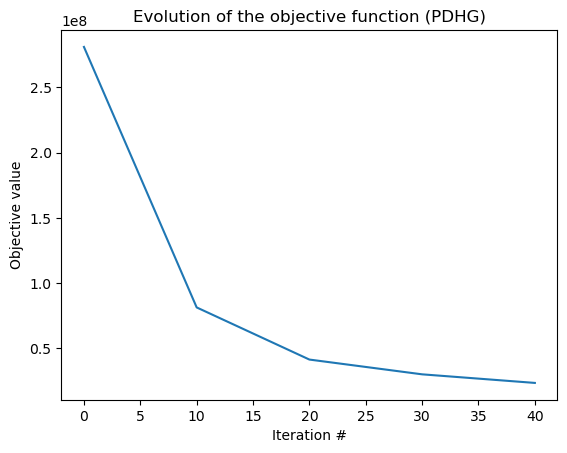

In [46]:
plt.title("Evolution of the objective function (PDHG)")
plt.plot(update_objective_interval*np.arange(len(pdhg.objective)), pdhg.objective)
plt.xlabel("Iteration #")
plt.ylabel("Objective value")

In [47]:
del recons_CIL, pdhg, writer, D, F, K, G

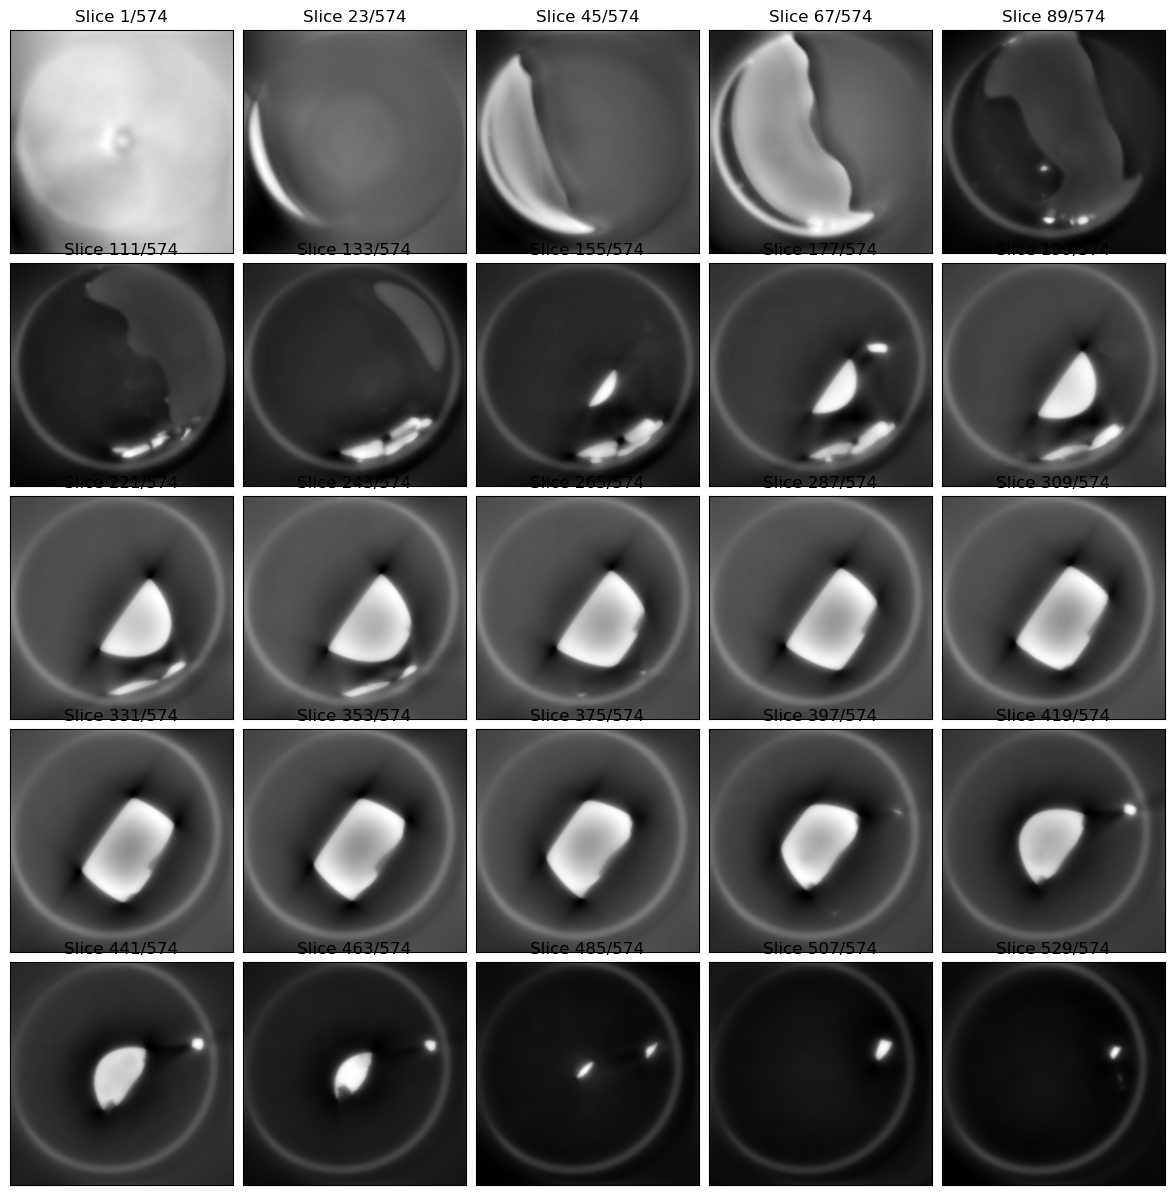

In [48]:
plot_grid(recons_PDHG_cil_array, 5, 5, title="Slice");

# Per-projection geometry with SPDHG

In [38]:
directory_path = os.path.join(parent_directory, "SPDHG");

if not os.path.exists(directory_path):
    os.mkdir(directory_path)

alpha = 0.02
D = GradientOperator(ig)
F = BlockFunction(L2NormSquared(b=data_corr), 
                  alpha*MixedL21Norm())
K = BlockOperator(A, 
                  D)
G = ZeroFunction()
update_objective_interval = 10
spdhg = SPDHG(initial=initial,
              f=F, 
              g=G, 
              operator=K, 
              max_iteration=10000, 
              update_objective_interval=update_objective_interval)

# Perform the CT reconstruction
spdhg.run(60, verbose=1, callbacks=[callbacks.TextProgressCallback()])

# Extract the solution
recons_CIL = spdhg.solution

writer = TIFFWriter(data=recons_CIL, file_name=os.path.join(directory_path, "slice"))
writer.write()

recons_SPDHG_cil_array = recons_CIL.as_array()

     0/60         ?it/s
    10/60     13.10s/it, objective=+6.435e+07
    20/60     12.51s/it, objective=+3.920e+07
    30/60     12.33s/it, objective=+8.118e+06
    40/60     11.90s/it, objective=+1.470e+07
    50/60     11.37s/it, objective=+7.604e+06
    60/60     11.03s/it, objective=+7.963e+06
    60/60     11.56s/it



Text(0, 0.5, 'Objective value')

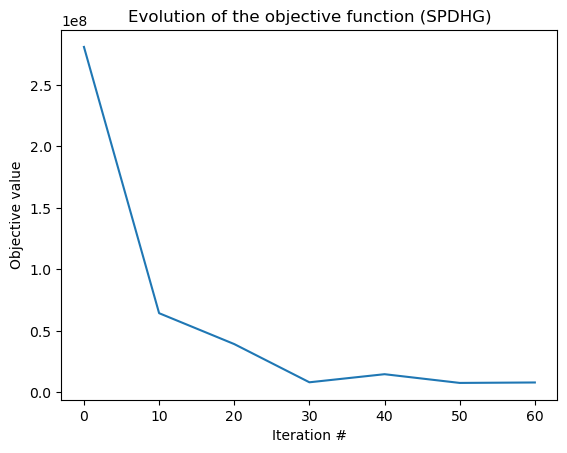

In [39]:
plt.title("Evolution of the objective function (SPDHG)")
plt.plot(update_objective_interval*np.arange(len(spdhg.objective)), spdhg.objective)
plt.xlabel("Iteration #")
plt.ylabel("Objective value")

In [61]:
del recons_CIL, spdhg, writer, D, F, K, G

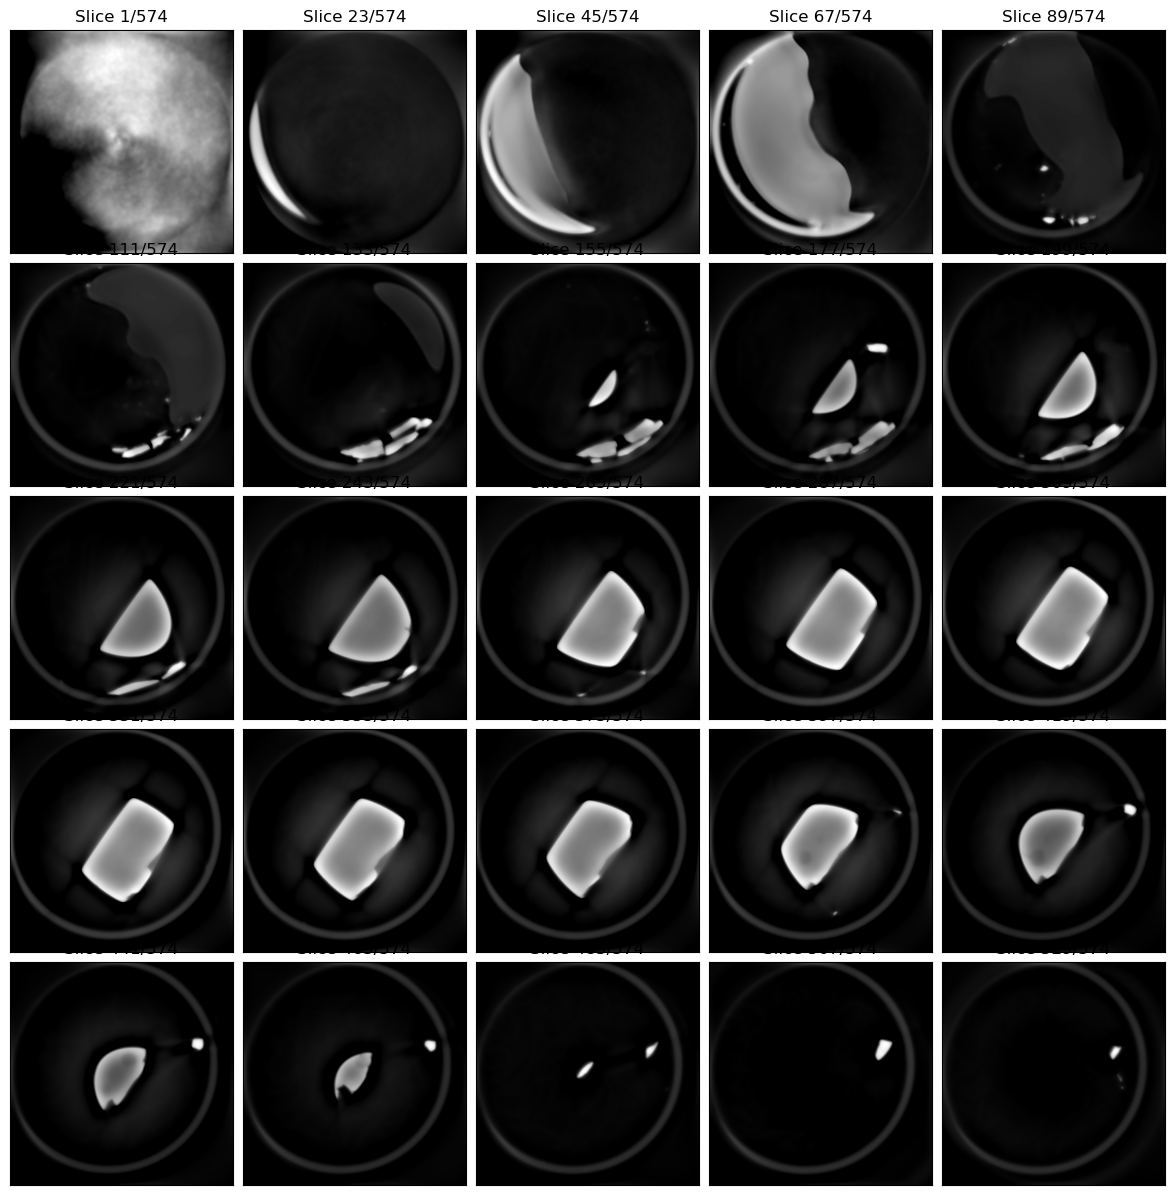

In [40]:
plot_grid(recons_SPDHG_cil_array, 5, 5, title="Slice", vmin=vmin);

# Per-projection geometry with FISTA

In [56]:
directory_path = os.path.join(parent_directory, "FISTA");

if not os.path.exists(directory_path):
    os.mkdir(directory_path)

alpha=0.025
F = LeastSquares(A = A, b = data_corr)
G = alpha*TotalVariation(lower=0)

update_objective_interval = 10
fista=FISTA(initial=initial,
            f=F,
            g=G,
            update_objective_interval=update_objective_interval)

# Perform the CT reconstruction
fista.run(20, verbose=1, callbacks=[callbacks.TextProgressCallback()])

# Extract the solution
recons_CIL = fista.solution

writer = TIFFWriter(data=recons_CIL, file_name=os.path.join(directory_path, "slice"))
writer.write()

recons_FISTA_cil_array = recons_CIL.as_array()

     0/20         ?it/s
    10/20     85.43s/it, objective=+2.275e+06
    20/20     85.80s/it, objective=+1.290e+06
    20/20     85.74s/it



Text(0, 0.5, 'Objective value')

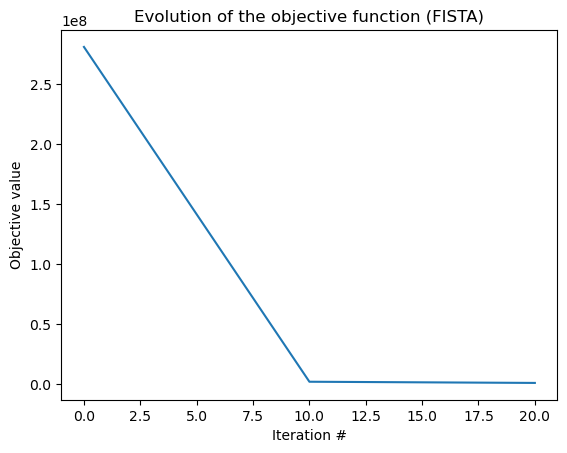

In [57]:
plt.title("Evolution of the objective function (FISTA)")
plt.plot(update_objective_interval*np.arange(len(fista.objective)), fista.objective)
plt.xlabel("Iteration #")
plt.ylabel("Objective value")

In [58]:
del recons_CIL, fista, writer, F, G

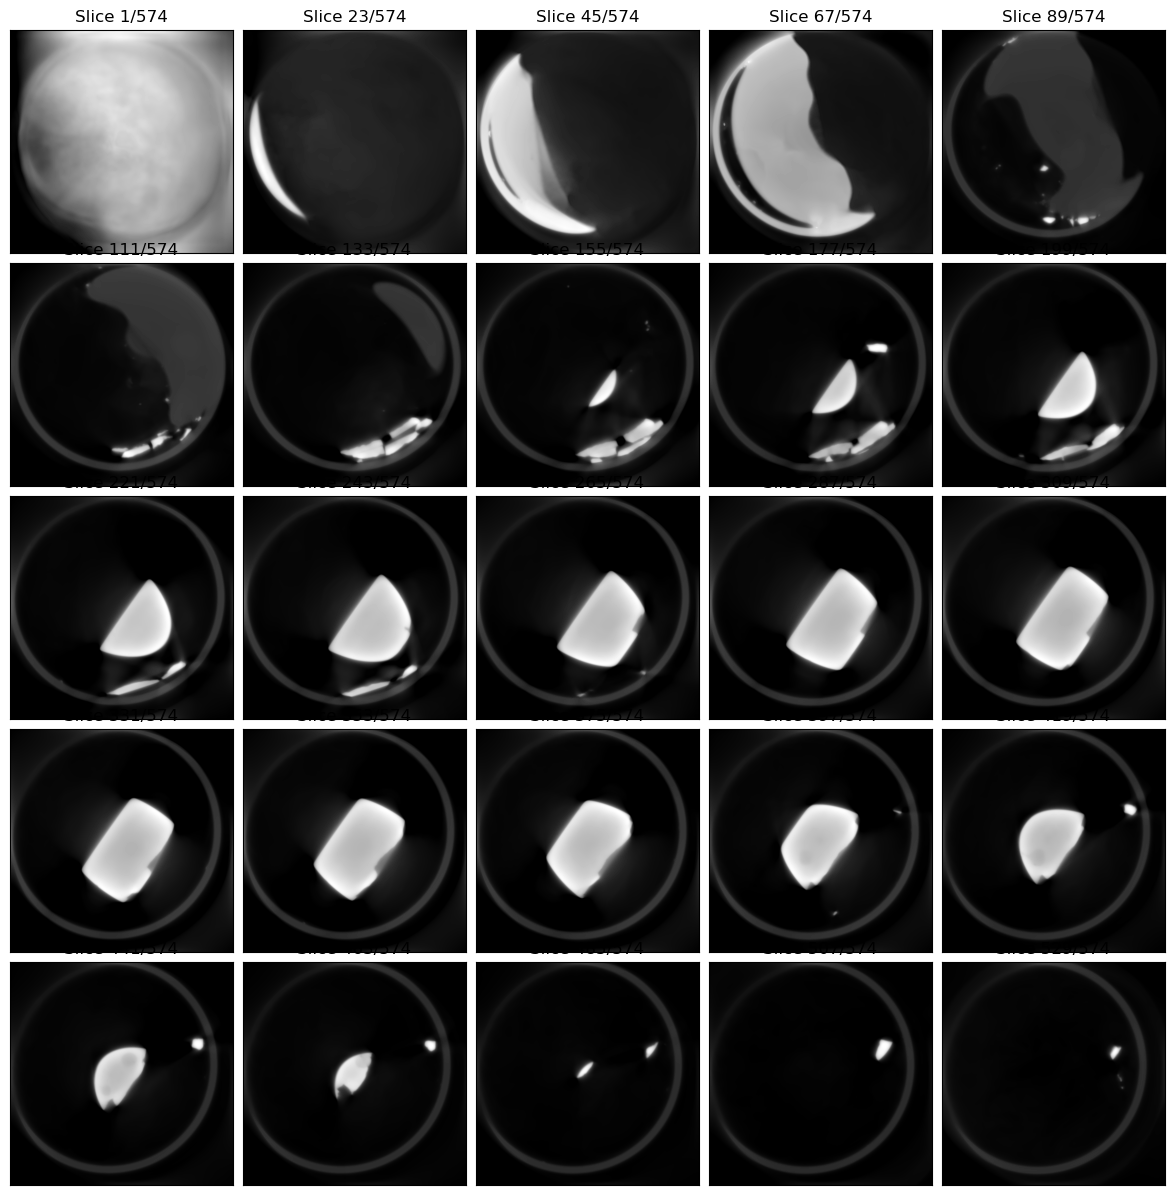

In [59]:
plot_grid(recons_FISTA_cil_array, 5, 5, title="Slice", vmin=vmin);

# Image comparison

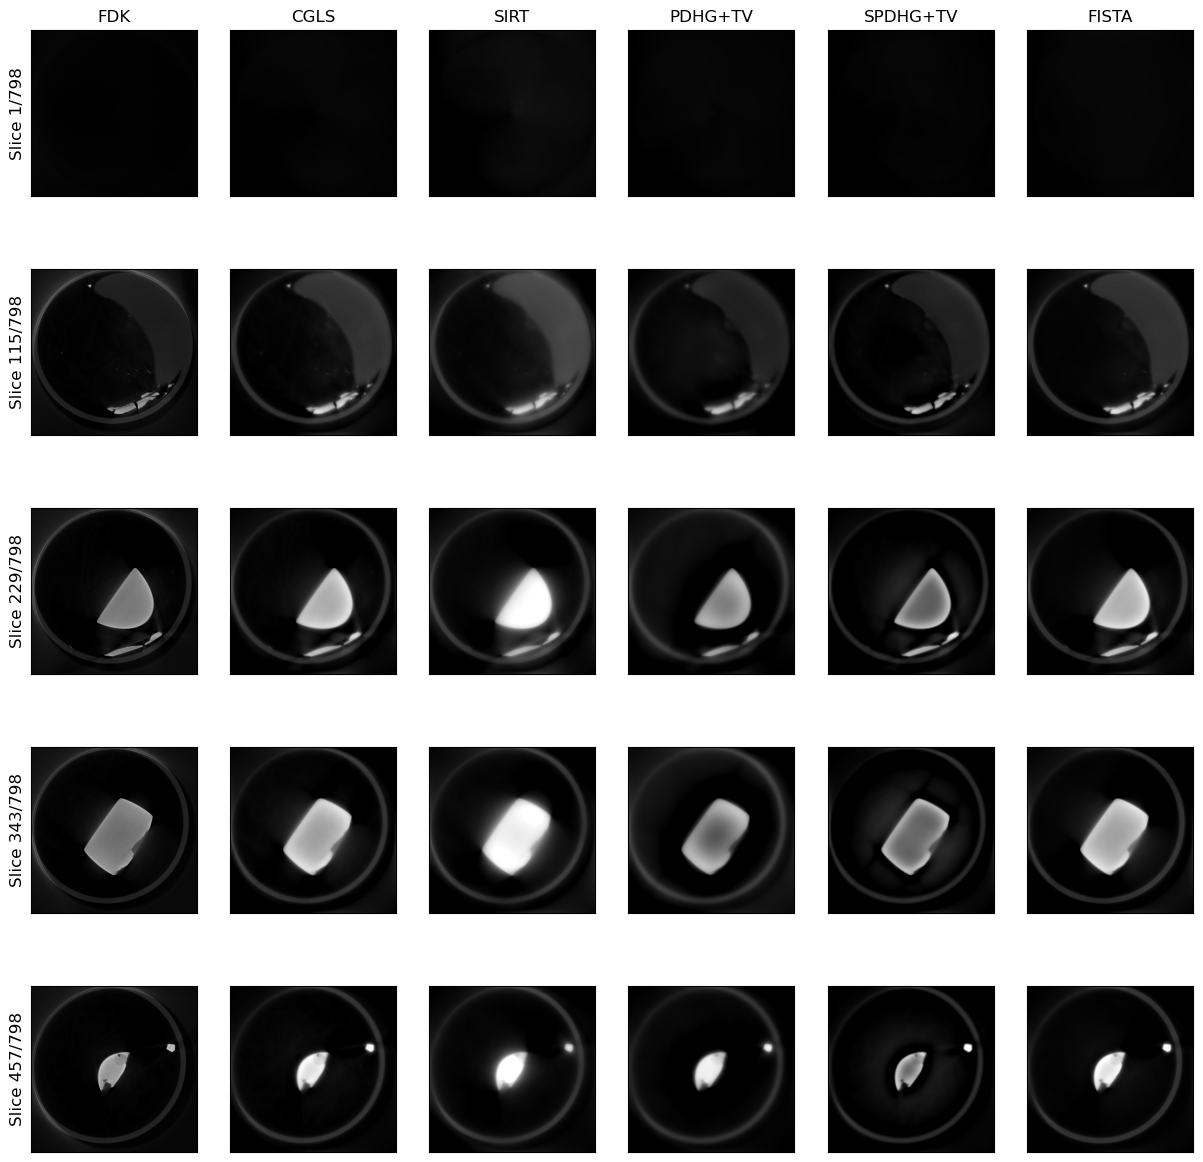

In [60]:
reconstruction_set = {
    
    "FDK": recons_FDK_cil_array,
    "CGLS": recons_CGLS_cil_array,
    "SIRT": recons_SIRT_cil_array,
    "PDHG+TV": recons_PDHG_cil_array,
    "SPDHG+TV": recons_SPDHG_cil_array,
    "FISTA": recons_FISTA_cil_array
};

comparison(reconstruction_set, 5, os.path.join(parent_directory, "comparison.png"))

In [ ]:
raise UserWarning('Exit Early')

3D volume rendering

In [68]:
bounds = [0, ig.voxel_num_x * ig.voxel_size_x, 0, ig.voxel_num_y * ig.voxel_size_y, 0, ig.voxel_num_z * ig.voxel_size_z]

k3d_volume = k3d.volume(recons_FDK_cil_array, bounds=bounds)

plot = k3d.plot()

plot += k3d_volume
value_range = [np.min(recons_FDK_cil_array), np.max(recons_FDK_cil_array)]
k3d_volume.alpha_coef = 5
k3d_volume.color_range = [value_range[0] + (value_range[1] - value_range[0]) / 3, value_range[1]]

plot.display()

Output()

In [ ]:
plot.fetch_screenshot()

In [ ]:
data = base64.b64decode(plot.screenshot);
with open(os.path.join(directory_path, "k3d_screenshot.png"), "wb") as fp:
    fp.write(data);
    fp.flush();
    fp.close();

In [ ]:
fista_number_of_iteration_slider = widgets.IntSlider(
    value=250,
    min=1,
    max=500,
    step=1,
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

HBox([Label('Number of iterations (FISTA):'), fista_number_of_iteration_slider])

In [ ]:
# run N interations
fista.run(fista_number_of_iteration_slider.value, callbacks=[callbacks.TextProgressCallback()])

In [ ]:
plt.plot(fista.objective)
plt.gca().set_yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Objective value')
plt.grid()

In [ ]:
# get and visualise the results
recon_FISTA = fista.solution

show2D([recons_FDK, recon_CGLS, recon_FISTA], ['FBP', 'CGLS', 'FISTA'], \
       num_cols=3, size=(15,10), origin='upper-left')

In [ ]:
raise UserWarning('Exit Early')

##### Crop the data

In [ ]:
# data_before = data_slice.copy()

# processor = Slicer(roi = {'horizontal':(500,2100,1)})
# processor.set_input(data_slice)
# data_slice = processor.get_output()

# show2D([data_before, data_slice], title=['Before cropping', 'After cropping'])


Compare the reconstruction

In [ ]:
# reco = FBP(data_slice).run(verbose=False)
# reco.apply_circular_mask(0.9)

# show2D([reco_before.array[1000:1100,1000:1100], reco.array[1000:1100,1000:1100]])

Plot a cross-section through the reconstruction

In [ ]:
# plt.plot(reco_before.array[1100,1100:1200])
# plt.plot(reco.array[1100,1100:1200])
# plt.xlabel('Horizontal x (pixels)')
# plt.ylabel('Intensity')
# plt.legend(['Before phase retrieval','After phase retrieval'])

##### Ring remover

Use the CIL ring remover processor to remove rings using a wavelet decomposition method

- Increasing sigma increases the frequency of ring artefacts that can be removed
- Increasing the number of decompositions  will increase the strength of the ring remover, but too high sigma will distort the profile of the image

In [ ]:
# data_before = data_slice.copy()
# reco_before = reco.copy()

As above, we can loop through different parameters and view the reconstructions with islicer

In [ ]:
array_list = []
array_list.append(reco.array)
decNum_list = [1, 10, 50, 100, 500]
for d in decNum_list:
    processor = RingRemover(decNum = d, wname = "db35", sigma = 1.5,  info = True)
    processor.set_input(data_corr)
    temp_data = processor.get_output()
    reco = FDK(temp_data, ig).run(verbose=False)
    array_list.append(reco.array[1])

In [ ]:
temp = []

for i in range(len(array_list)):
    show2D(array_list[i][1])

In [ ]:
DC = DataContainer(np.stack(temp, axis=0), dimension_labels=tuple(['Ring remover decNum']) + reco.geometry.dimension_labels)


There's a ring visible at (700-1100, 700-1100). Cycle through the slices to see how well it is removed

In [ ]:
islicer(DC, slice_number=0)


Choose the preferred ring removal method and apply it to the data 

In [ ]:
best_snr = 5
data_slice = rem.remove_all_stripe(data_before.as_array(), best_snr, 5, 1)
data_slice = AcquisitionData(data_slice.astype(np.float32), geometry=data_before.geometry)
reco = FBP(data_slice).run(verbose=False)
show2D([reco_before.array[700:1000,700:1000], reco.array[700:1000,700:1000]])

##### Save the processed data

Once we've happy with the reconstruction save the processed data as TIFF

In [ ]:
writer = TIFFWriter()
writer.set_up(data = data_slice, file_name='path_to_data/data.tiff') #add data type, cast to float16
# writer.write()